In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [ ]:
data = pd.read_csv(r'Dataset.csv')
data = data.drop('Date', axis=1)
data

,Ch 278,Ch 279,Ch 280,Ch 281,Ch 282,Ch 283,Ch 284,Ch 285,Ch 303,Ch 1195,...,Ch 1648,Ch 1649,Ch 1650,Ch 1651,Ch 1664,Ch 1773,Ch 1780,Ch 1817,Instance,TTF
0,74.7,87.4,4.1,1473.0,1.1,1.1,351.0,375.0,2.7,415,...,4.3,276.6,255.4,10.3,0,0,1,1,145,3.0
1,74.7,87.5,4.1,1473.0,1.1,1.2,351.0,375.0,2.7,415,...,4.6,269.1,247.5,0.0,0,1,1,1,145,2.5
2,74.7,87.4,4.1,1473.0,1.1,1.1,351.0,375.0,2.7,415,...,4.5,263.4,241.6,0.2,0,1,1,1,145,2.0
3,74.8,87.4,4.1,1473.0,1.1,1.1,352.0,376.0,2.6,415,...,4.5,258.0,235.8,0.2,0,1,1,1,145,1.5
4,74.8,87.4,4.1,1473.0,1.1,1.0,351.0,375.0,2.6,415,...,4.6,246.4,225.3,0.6,0,1,1,1,145,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,2.0
468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,1.5
469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,1.0
470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,0.5


In [ ]:
def series_to_supervised(data, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.drop('Instance',axis=1).shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.drop('Instance',axis=1).columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
final_data = pd.DataFrame()


for inst, df in data.groupby('Instance'):
  df_n = series_to_supervised(df).drop(['TTF(t-1)'],axis=1)
  final_data = final_data.append(df_n)

final_data

,Ch 278(t-1),Ch 279(t-1),Ch 280(t-1),Ch 281(t-1),Ch 282(t-1),Ch 283(t-1),Ch 284(t-1),Ch 285(t-1),Ch 303(t-1),Ch 1195(t-1),...,Ch 1648(t),Ch 1649(t),Ch 1650(t),Ch 1651(t),Ch 1664(t),Ch 1773(t),Ch 1780(t),Ch 1817(t),Instance(t),TTF(t)
1,74.7,87.4,4.1,1473.0,1.1,1.1,351.0,375.0,2.7,415.0,...,4.6,269.1,247.5,0.0,0,1,1,1,145,2.5
2,74.7,87.5,4.1,1473.0,1.1,1.2,351.0,375.0,2.7,415.0,...,4.5,263.4,241.6,0.2,0,1,1,1,145,2.0
3,74.7,87.4,4.1,1473.0,1.1,1.1,351.0,375.0,2.7,415.0,...,4.5,258.0,235.8,0.2,0,1,1,1,145,1.5
4,74.8,87.4,4.1,1473.0,1.1,1.1,352.0,376.0,2.6,415.0,...,4.6,246.4,225.3,0.6,0,1,1,1,145,1.0
5,74.8,87.4,4.1,1473.0,1.1,1.0,351.0,375.0,2.6,415.0,...,4.5,251.2,232.8,0.7,0,1,1,1,145,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,2.0
468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,1.5
469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,1.0
470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,1,1,222,0.5


In [ ]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for inst, df in final_data.groupby('Instance(t)'):

  df = df.drop('Instance(t)',axis=1)

  train_size = int(len(df) * 0.80)
  test_size = len(df) - train_size

  train_data = train_data.append(df.iloc[0:train_size,:])
  test_data = test_data.append(df.iloc[train_size:len(df),:])

In [ ]:
scaler = MinMaxScaler()

scaled_trainX = scaler.fit_transform(train_data.drop('TTF(t)',axis=1))
scaled_testX = scaler.transform(test_data.drop('TTF(t)',axis=1))

In [ ]:
scaled_trainX = np.c_[scaled_trainX, train_data['TTF(t)'].values]
scaled_testX = np.c_[scaled_testX, test_data['TTF(t)'].values]

In [ ]:
trainX, trainY = scaled_trainX[:,:-1], scaled_trainX[:,-1]
testX, testY = scaled_testX[:,:-1], scaled_testX[:,-1]

In [ ]:
# model = Sequential()
# model.add(LSTM(80, return_sequences=True, input_shape=(trainX.shape[1],1)))
# model.add(LSTM(40, return_sequences=True))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# model.fit(trainX, trainY, epochs=20, batch_size=2, validation_data=(testX, testY))

In [ ]:
def get_results(model):

  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = np.sqrt(mean_squared_error(testY, testPredict))
  print('Test Score: %.2f RMSE' % (testScore))

  return pd.DataFrame({'trainActual':trainY, 'trainPredicted':trainPredict}), pd.DataFrame({'testActual':testY, 'testPredicted':testPredict}) 

[10:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train Score: 9.35 RMSE
Test Score: 35.04 RMSE


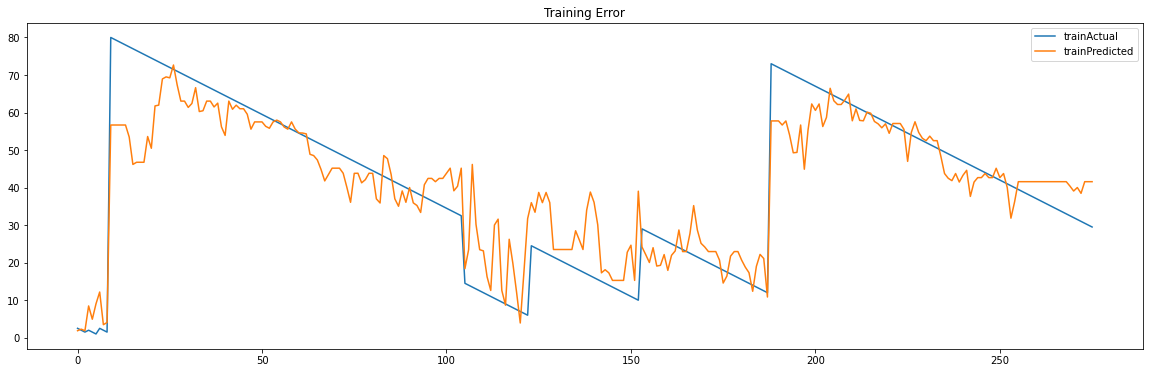

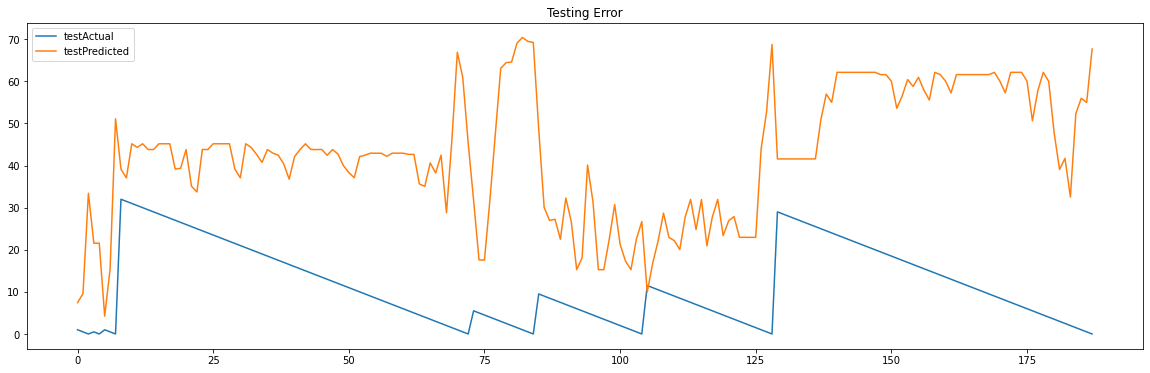

In [ ]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(trainX, trainY, eval_set=[(trainX, trainY), (testX, testY)], verbose=False)

train_reg, test_reg = get_results(reg)

train_reg.plot(figsize=(20,6))
plt.title('Training Error')
plt.show()

test_reg.plot(figsize=(20,6))
plt.title('Testing Error')
plt.show()

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(128, activation='sigmoid', input_dim=trainX.shape[1]))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(64, activation='sigmoid'))
model_mlp.add(Dropout(0.1))
model_mlp.add(Dense(8, activation='sigmoid'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer='adam')

In [ ]:
model_mlp.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(testX, testY))

Epoch 1/25
276/276 [==============================] - 1s 3ms/step - loss: 1965.7654 - val_loss: 149.9869
Epoch 2/25
276/276 [==============================] - 1s 3ms/step - loss: 1810.4885 - val_loss: 120.6481
Epoch 3/25
276/276 [==============================] - 1s 3ms/step - loss: 1662.8932 - val_loss: 101.1593
Epoch 4/25
276/276 [==============================] - 1s 3ms/step - loss: 1537.2587 - val_loss: 89.7937
Epoch 5/25
276/276 [==============================] - 1s 3ms/step - loss: 1424.3929 - val_loss: 84.9563
Epoch 6/25
276/276 [==============================] - 1s 3ms/step - loss: 1321.9617 - val_loss: 86.0002
Epoch 7/25
276/276 [==============================] - 1s 3ms/step - loss: 1228.6953 - val_loss: 92.2753
Epoch 8/25
276/276 [==============================] - 1s 3ms/step - loss: 1143.5857 - val_loss: 102.8937
Epoch 9/25
276/276 [==============================] - 1s 3ms/step - loss: 1065.3344 - val_loss: 115.6270
Epoch 10/25
276/276 [==============================] - 1s 3